# Convolutional Neural Networks (CNN)

In this notebook, we first run a simple baseline CNN. We notice that the model is slightly overfitting, achieving nearly 100% training accuracy. So, we attempt several implementation to reduce the complexity of the model.

In [1]:
# Necessary Imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plotting learning curves
def plot_accuracy(model, history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

In [3]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

X_train = train.drop(columns = 'label')
X_test = test.drop(columns = 'label')

# Check that data is input properly - pixel values in range 0-255
column_val = 'pixel{value}'
for i in range(1, 785):
    if (X_train[column_val.format(value=i)] < 0).any() or (X_train[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in training data pixel column {value}".format(value=i))
    if (X_test[column_val.format(value=i)] < 0).any() or (X_test[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in testing data pixel column {value}".format(value=i))
print("If this is the only message, then all data is good to go!")

# Normalize the data
X_train /= 255.0
X_test /= 255.0

# Reshape to be compatible with input layer
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# Get target classes
y_train = train['label']
y_test = test['label']

If this is the only message, then all data is good to go!


## Model 1: Baseline

A baseline model is run to get an idea of the achievable accuracy from a simple neural network, not paying too much attention to the number or makeup of the layers.

In [4]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(25))
model_1.summary()

2022-06-09 17:54:14.117390: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-09 17:54:14.142019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [5]:
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_1 = model_1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2022-06-09 17:54:17.236083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
858/858 [==============================] - 57s 60ms/step - loss: 1.9981 - accuracy: 0.3922 - val_loss: 0.5763 - val_accuracy: 0.8109
Epoch 2/10
858/858 [==============================] - 43s 50ms/step - loss: 0.1519 - accuracy: 0.9551 - val_loss: 0.3215 - val_accuracy: 0.9021
Epoch 3/10
858/858 [==============================] - 31s 36ms/step - loss: 0.0278 - accuracy: 0.9935 - val_loss: 0.4593 - val_accuracy: 0.8705
Epoch 4/10
858/858 [==============================] - 37s 44ms/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.3301 - val_accuracy: 0.9222
Epoch 5/10
858/858 [==============================] - 36s 42ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.9225
Epoch 6/10
858/858 [==============================] - 33s 39ms/step - loss: 3.6703e-04 - accuracy: 1.0000 - val_loss: 0.3869 - val_accuracy: 0.9207
Epoch 7/10
858/858 [==============================] - 34s 40ms/step - loss: 0.0504 - accuracy: 0.9846 - val_loss: 0.2778 - val_accur

Testing Loss: 0.3262122571468353
Testing Accuracy: 0.9304238557815552
Training Accuracy: 1.0


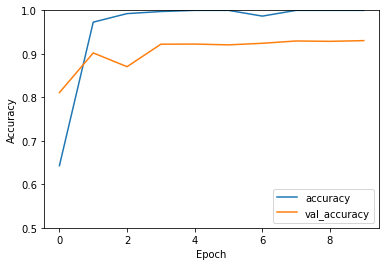

In [6]:
test_loss1, test_acc1 = model_1.evaluate(X_test,  y_test, verbose = 0)
training_acc1 = history_1.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss1, test_acc1, training_acc1))
plot_accuracy(model_1, history_1)

## Model 2: L2 Regularization

L2 regularization is applied to the Convolutional2D layers. 

It is clear that when applying l2 regularization, training is much slower. Here, a learning rate of 0.005 is used and the training learning curve plateaus at around 20 epochs. When using the default learning rate of 0.01 here, the learning curves are still gradually increasing after 100 epochs. There may be some promise here, but in consideration of time, there are likely more efficient methods. 

In [7]:
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.005)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.005)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model_2.add(layers.Dense(25, kernel_regularizer='l2'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [8]:
model_2.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
858/858 [==============================] - 29s 33ms/step - loss: 3.4826 - accuracy: 0.0655 - val_loss: 2.4878 - val_accuracy: 0.2393
Epoch 2/100
858/858 [==============================] - 27s 32ms/step - loss: 2.1112 - accuracy: 0.3615 - val_loss: 1.9244 - val_accuracy: 0.4596
Epoch 3/100
858/858 [==============================] - 40s 47ms/step - loss: 1.5486 - accuracy: 0.5849 - val_loss: 1.5773 - val_accuracy: 0.6076
Epoch 4/100
858/858 [==============================] - 38s 44ms/step - loss: 1.2221 - accuracy: 0.7106 - val_loss: 1.4356 - val_accuracy: 0.6615
Epoch 5/100
858/858 [==============================] - 44s 51ms/step - loss: 1.0291 - accuracy: 0.7846 - val_loss: 1.4068 - val_accuracy: 0.6969
Epoch 6/100
858/858 [==============================] - 34s 39ms/step - loss: 0.9041 - accuracy: 0.8301 - val_loss: 1.3437 - val_accuracy: 0.7027
Epoch 7/100
858/858 [==============================] - 42s 48ms/step - loss: 0.8096 - accuracy: 0.8774 - val_loss: 1.2924 - val_ac

Testing Loss: 0.8063716292381287
Testing Accuracy: 0.8423033952713013
Training Accuracy: 0.9967219233512878


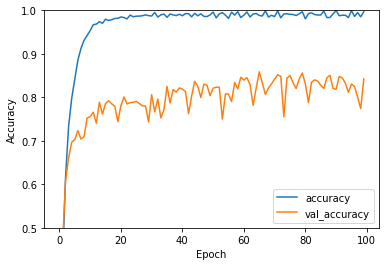

In [9]:
test_loss2, test_acc2 = model_2.evaluate(X_test,  y_test, verbose = 0)
training_acc2 = history_2.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss2, test_acc2, training_acc2))
plot_accuracy(model_2, history_2)

## Model 3: Dropout Layers
After Conv2D Layers

Dropout layers reduces the complexity of the neural network by randomly terminating a specified proportion of nodes. Here, 20% of the nodes are removed after the 2nd and 3rd Conv2D layers. 

In [10]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(25))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 64)         

In [11]:
model_3.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_3 = model_3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 48s 54ms/step - loss: 1.9228 - accuracy: 0.4165 - val_loss: 0.4329 - val_accuracy: 0.8667
Epoch 2/10
858/858 [==============================] - 48s 56ms/step - loss: 0.1947 - accuracy: 0.9356 - val_loss: 0.3334 - val_accuracy: 0.9084
Epoch 3/10
858/858 [==============================] - 39s 45ms/step - loss: 0.0709 - accuracy: 0.9783 - val_loss: 0.4245 - val_accuracy: 0.8813
Epoch 4/10
858/858 [==============================] - 47s 55ms/step - loss: 0.0445 - accuracy: 0.9858 - val_loss: 0.3133 - val_accuracy: 0.9170
Epoch 5/10
858/858 [==============================] - 50s 58ms/step - loss: 0.0297 - accuracy: 0.9911 - val_loss: 0.2619 - val_accuracy: 0.9459
Epoch 6/10
858/858 [==============================] - 48s 56ms/step - loss: 0.0245 - accuracy: 0.9923 - val_loss: 0.2746 - val_accuracy: 0.9426
Epoch 7/10
858/858 [==============================] - 45s 52ms/step - loss: 0.0184 - accuracy: 0.9939 - val_loss: 0.2838 - val_accuracy:

Testing Loss: 0.3249976336956024
Testing Accuracy: 0.9369771480560303
Training Accuracy: 0.9937716126441956


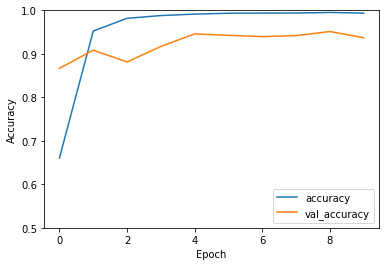

In [12]:
test_loss3, test_acc3 = model_3.evaluate(X_test,  y_test, verbose = 0)
training_acc3 = history_3.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss3, test_acc3, training_acc3))
plot_accuracy(model_3, history_3)

## Model 4: Weight Initialization

Using the `he_normal` weight initialization, the training accuracy approaches 100% in just three iterations. A different approach would be better. 

In [13]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer= 'he_normal', input_shape=(28, 28, 1)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(25))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [14]:
model_4.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_4 = model_4.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 27s 31ms/step - loss: 1.6326 - accuracy: 0.5152 - val_loss: 0.4717 - val_accuracy: 0.8652
Epoch 2/10
858/858 [==============================] - 25s 29ms/step - loss: 0.0606 - accuracy: 0.9855 - val_loss: 0.4488 - val_accuracy: 0.9091
Epoch 3/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0183 - accuracy: 0.9956 - val_loss: 0.4738 - val_accuracy: 0.9078
Epoch 4/10
858/858 [==============================] - 25s 29ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.4584 - val_accuracy: 0.8919
Epoch 5/10
858/858 [==============================] - 24s 28ms/step - loss: 0.0068 - accuracy: 0.9986 - val_loss: 0.4575 - val_accuracy: 0.9076
Epoch 6/10
858/858 [==============================] - 25s 29ms/step - loss: 2.0308e-04 - accuracy: 1.0000 - val_loss: 0.4750 - val_accuracy: 0.9110
Epoch 7/10
858/858 [==============================] - 26s 30ms/step - loss: 1.0786e-04 - accuracy: 1.0000 - val_loss: 0.4943 - val_a

Testing Loss: 0.4303167462348938
Testing Accuracy: 0.9254043698310852
Training Accuracy: 0.9906027913093567


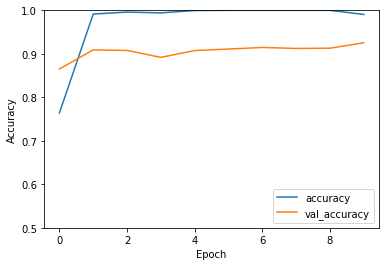

In [15]:
test_loss4, test_acc4 = model_4.evaluate(X_test,  y_test, verbose = 0)
training_acc4 = history_4.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss4, test_acc4, training_acc4))
plot_accuracy(model_4, history_4)

## Model 5: Dropout
After MaxPooling

The addition of dropout layers appeared to be a promising approach. Other articles online indicated that placement of Dropout layers after MaxPooling is also effective. This is applied here, along with the addition of another Conv2D -> MaxPooling. The testing accuracy here is the best so far at 94.8 %, while the training accuracy is at 96.9%. This appears to generalize better being less complex than the baseline model which reached a 100% training accuracy.

In [16]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dense(25))
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 64)         

In [17]:
model_5.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])
history_5 = model_5.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
858/858 [==============================] - 27s 30ms/step - loss: 2.6140 - accuracy: 0.1951 - val_loss: 0.8425 - val_accuracy: 0.7121
Epoch 2/10
858/858 [==============================] - 29s 34ms/step - loss: 0.8263 - accuracy: 0.7191 - val_loss: 0.4904 - val_accuracy: 0.8245
Epoch 3/10
858/858 [==============================] - 30s 35ms/step - loss: 0.4735 - accuracy: 0.8410 - val_loss: 0.3603 - val_accuracy: 0.8659
Epoch 4/10
858/858 [==============================] - 27s 32ms/step - loss: 0.3119 - accuracy: 0.8962 - val_loss: 0.2551 - val_accuracy: 0.9081
Epoch 5/10
858/858 [==============================] - 31s 37ms/step - loss: 0.2325 - accuracy: 0.9223 - val_loss: 0.2526 - val_accuracy: 0.9073
Epoch 6/10
858/858 [==============================] - 30s 35ms/step - loss: 0.1773 - accuracy: 0.9413 - val_loss: 0.2317 - val_accuracy: 0.9382
Epoch 7/10
858/858 [==============================] - 26s 30ms/step - loss: 0.1495 - accuracy: 0.9511 - val_loss: 0.2088 - val_accuracy:

Testing Loss: 0.1924448162317276
Testing Accuracy: 0.9484105110168457
Training Accuracy: 0.968639612197876


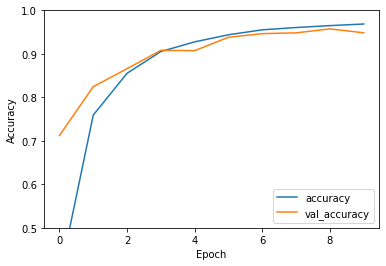

In [18]:
test_loss5, test_acc5 = model_5.evaluate(X_test,  y_test, verbose = 0)
training_acc5 = history_5.history['accuracy'][-1]
print('Testing Loss: {}\nTesting Accuracy: {}\nTraining Accuracy: {}'.format(test_loss5, test_acc5, training_acc5))
plot_accuracy(model_5, history_5)

In [22]:
training_acc = [training_acc1, training_acc2, training_acc3, training_acc4, training_acc5]
testing_acc = [test_acc1, test_acc2, test_acc3, test_acc4, test_acc5]
testing_loss = [test_loss1, test_loss2, test_loss3, test_loss4, test_loss5]

results_dict = {'Training Accuracy': training_acc, 'Testing Accuracy': testing_acc, 'Testing Loss': testing_loss}
results = pd.DataFrame(results_dict)
results

,Training Accuracy,Testing Accuracy,Testing Loss
0,1.000000,0.930424,0.326212
1,0.996722,0.842303,0.806372
2,0.993772,0.936977,0.324998
3,0.990603,0.925404,0.430317
4,0.968640,0.948411,0.192445


##